<a href="https://colab.research.google.com/github/meituan/YOLOv6/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
#@title Set-up model. { run: "auto" }
checkpoint:str ="yolov6s" #@param ["yolov6s", "yolov6n", "yolov6t"]
device:str = "cpu"#@param ["gpu", "cpu"]
half:bool = False #@param {type:"boolean"}

import matplotlib.pyplot as plt 
import os, requests, torch, math, cv2
import numpy as np
import PIL
from PIL import Image
#Change directory so that imports wortk correctly
if os.getcwd()=="/content":
  os.chdir("YOLOv6")
from yolov6.utils.events import LOGGER, load_yaml
from yolov6.layers.common import DetectBackend
from yolov6.data.data_augment import letterbox
from yolov6.utils.nms import non_max_suppression
from yolov6.core.inferer import Inferer

from typing import List, Optional
#Download weights
if not os.path.exists(f"{checkpoint}.pt"):
  print("Downloading checkpoint...")
  os.system(f"""wget -c https://github.com/meituan/YOLOv6/releases/download/0.2.0/{checkpoint}.pt""")

#Set-up hardware options
cuda = device != 'cpu' and torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')
  
def check_img_size(img_size, s=32, floor=0):
  def make_divisible( x, divisor):
    # Upward revision the value x to make it evenly divisible by the divisor.
    return math.ceil(x / divisor) * divisor
  """Make sure image size is a multiple of stride s in each dimension, and return a new shape list of image."""
  if isinstance(img_size, int):  # integer i.e. img_size=640
      new_size = max(make_divisible(img_size, int(s)), floor)
  elif isinstance(img_size, list):  # list i.e. img_size=[640, 480]
      new_size = [max(make_divisible(x, int(s)), floor) for x in img_size]
  else:
      raise Exception(f"Unsupported type of img_size: {type(img_size)}")

  if new_size != img_size:
      print(f'WARNING: --img-size {img_size} must be multiple of max stride {s}, updating to {new_size}')
  return new_size if isinstance(img_size,list) else [new_size]*2

def precess_image(img_c, img_size, stride, half):
  
  img_src = np.asarray(img_c)
  image = letterbox(img_src, img_size, stride=stride)[0]
  # Convert
  image = image.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
  image = torch.from_numpy(np.ascontiguousarray(image))
  image = image.half() if half else image.float()  # uint8 to fp16/32
  image /= 255  # 0 - 255 to 0.0 - 1.0

  return image, img_src


model = DetectBackend(f"./{checkpoint}.pt", device=device)
stride = model.stride
class_names = load_yaml("./data/coco.yaml")['names']

if half & (device.type != 'cpu'):
  model.model.half()
else:
  model.model.float()
  half = False

if device.type != 'cpu':
  model(torch.zeros(1, 3, *img_size).to(device).type_as(next(model.model.parameters())))  # warmup


Loading checkpoint from ./yolov6s.pt

Fusing model...


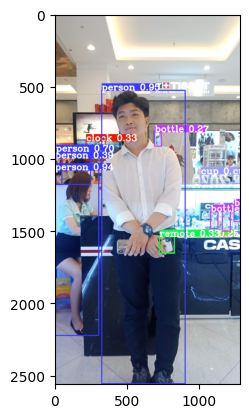

In [55]:
def ok():
   
    #url:str = "images/1.JPG" 
   #img_c = cv2.cvtColor(cv2.imread(url), cv2.COLOR_BGR2RGB)
    
    hide_labels: bool = False 
    hide_conf: bool = False
    img_size:int = 640

    conf_thres: float =.25 
    iou_thres: float =.45 
    max_det:int =  1000
    agnostic_nms: bool = False 


    img_size = check_img_size(img_size, s=stride)

    img, img_src = precess_image(img_c, img_size, stride, half)
    img = img.to(device)
    if len(img.shape) == 3:
        img = img[None]

    pred_results = model(img)
    classes:Optional[List[int]] = None 
    det = non_max_suppression(pred_results, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)[0]

    gn = torch.tensor(img_src.shape)[[1, 0, 1, 0]]  
    img_ori = img_src.copy()
    if len(det):
      det[:, :4] = Inferer.rescale(img.shape[2:], det[:, :4], img_src.shape).round()
      for *xyxy, conf, cls in reversed(det):
          class_num = int(cls)
          label = None if hide_labels else (class_names[class_num] if hide_conf else f'{class_names[class_num]} {conf:.2f}')
          Inferer.plot_box_and_label(img_ori, max(round(sum(img_ori.shape) / 2 * 0.003), 2), xyxy, label, color=Inferer.generate_colors(class_num, True))

    return (img_ori)
    
plt.imshow(ok())